## Overview
**Context**: This dataset contains published iTRAQ proteome profiling of 77 breast cancer samples generated by the *Clinical Proteomic Tumor Analysis Consortium (NCI/NIH)*. It contains expression values for ~12.000 proteins for each sample, with missing values present when a given protein could not be quantified in a given sample.

**Previous Research**: *http://www.nature.com/nature/journal/v534/n7605/full/nature18003.html*   
In short: They performed K-means clustering on the protein data to divide the breast cancer patients into sub-types, each having unique protein expression signature. They found that the best clustering was achieved using 3 clusters (original PAM50 gene set yields four different subtypes using RNA data).

**Source**: the datasets are provided by @kajot from kaggle https://www.kaggle.com/piotrgrabo/breastcancerproteomes

### Goal
My goal here is to explore this dataset to check if I could reproduce previous research. **More importantly,** I would like to explore t-sne algorithm in details to visualize how the t-sne seperate different clusters. This is a important tool for Drop-Seq data analysis *(http://www.cell.com/cell/abstract/S0092-8674(15)00549-8)* as an early stage to explore the potential molecular mechanisms, which will help me when my thesis project moves forward to the Drop-Seq stage.

### Outline

1. Import datasets and clean up     
    to import the datasets and clean it up. Mainly, keep the format of the TCID correct.
2. Merge two datasets     
    to merge the proteome data and clinic data together so that we have both 'features' and 'targets' for visulization and machine learning

3. Prepare data for Machine Leaning   
    to fillna in the original datasets by mediam and extract features and targets for later analysis
4. Use t-sne and PCA to visualize data structure    
    to visualize the data structure to check if there are clusters in the datasets, and if it will be easy to seperate different clusters
4. **Explore visualization using t-sne** (This is the interesting section and could be used later in my project)    
    to visualize the intermediate steps of t-sne transformation
5. Extract the correct feature sets    
    to extract the correct feature sets so that it is easier to find patient clusters and seperate them
6. Machine Learning    
    To test if ML models could tell the patients apart from PAM50 proteome data
7. Future Disccusion    
    To discuss potential follow-ups

In [1]:
# import basic modules
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

## Import datasets and clean up
In this section, I will import the datasets and clean it up. Mainly, keep the format of the TCID correct.

In [2]:
prot_file = 'breastcancerproteomes/77_cancer_proteomes_CPTAC_itraq.csv'

**A short description of 77_cancer_proteomes_CPTAC_itraq.csv**

1. RefSeq_accession_number: RefSeq protein ID (each protein has a unique ID in a RefSeq database)
2. gene_symbol: a symbol unique to each gene (every protein is encoded by some gene)
3. gene_name: a full name of that gene Remaining columns: log2 iTRAQ ratios for each sample (protein expression data, most important)
4. **three last columns are from healthy individuals**

In [3]:
proteome = pd.read_csv(prot_file)
print('the dimension of this dataset is ', proteome.shape)
# proteome.head()
# Originally, first few columns are protein/gene infromation, they will be cleaned up later.

the dimension of this dataset is  (12553, 86)


In [4]:
clinic_file = 'breastcancerproteomes/clinical_data_breast_cancer.csv'

**A short description of clinical_data_breast_cancer.csv**
1. First column "Complete TCGA ID" is used to match the sample IDs in the main cancer proteomes file. 
2. All other columns have self-explanatory names, contain data about the cancer classification of a given sample using different methods.

In [5]:
clinic = pd.read_csv(clinic_file, index_col=0)
print('the dimension of clinic file is ', clinic.shape)
# clinic.head()

the dimension of clinic file is  (105, 29)


**Main goal in this section:**   
The TCGA_IDs don't match between two datasets, thus, change the name accordingly to fit the complete TCGA_ID format.

In [6]:
# define a function to change the name. the format is pretty predictable, so the change is easy
original_name = list(proteome.columns)
def change_TCGA_ID(name):
    return name[-4:] + '-' + name[:7]
modified_name = original_name[:3] + [change_TCGA_ID(_) for _ in original_name[3: -3]] + original_name[-3:]

In [7]:
# change the format
proteome.columns = modified_name

In [8]:
# check if the TCGA_ID format is correct in the proteome dataframe
proteome.head()
# pretty good

,RefSeq_accession_number,gene_symbol,gene_name,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
0,NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
1,NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
2,NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
3,NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
4,NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [9]:
# save this pd into a temp csv file
# end of section 1, import datasets and clean up
proteome.to_csv('77_cancer_proteomes_CPTAC_itraq.csv_with_changed_name.csv')

### Merge two datasets together for visualization and ML analysis  
The goal is here is to merge the proteome data and clinic data together so that we have both 'features' and 'targets' for visulization and machine learning.

In [10]:
# re-read the dataset and change the index of proteome to RefSeq_accession_number
proteome = pd.read_csv('77_cancer_proteomes_CPTAC_itraq.csv_with_changed_name.csv', index_col=0)
# drop the gene symbol and gene_name
proteome.drop(['gene_symbol', 'gene_name'], axis=1, inplace=True)

In [11]:
# transpose the proteosome to prepare for merging
proteome = proteome.transpose()
proteome.columns = proteome.ix[0, :]
proteome=proteome.ix[1:, :]
proteome.head()
proteome.to_csv('77_cancer_proteomes_CPTAC_itraq_transposed.csv')

In [12]:
# Drop the clinical samples that are not in the protein data set
clinic = clinic.loc[[_ for _ in clinic.index.tolist() if _ in proteome.index], :]
# clinic.head()

In [13]:
# merge two datasets together and save it as a temp csv
merge_proteome_clinic = proteome.merge(clinic,left_index=True,right_index=True)
merge_proteome_clinic.to_csv('merge_proteome_clinic.csv')
# the merge_proteome_clinic.csv will be the start point of visualization and ML

### Prepare data for visualization and machine learning
The goal here is to fillna in the original datasets by mediam and extract features and targets for later analysis

In [14]:
# read the merged datasets from the last section
merge = pd.read_csv('merge_proteome_clinic.csv', index_col=0)
# merge.head()

In [15]:
# proteome here will be the features
proteome = merge.ix[:, :12553]
# proteome.head()

In [16]:
# use imputer to fillna with median protein level (This is arguable if it is the best approach)
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(proteome)
processed_proteome = imputer.transform(proteome)

In [17]:
# X is the array of features
X = processed_proteome

In [18]:
# transform the strings into categoris and assign labels to them to get the targets
merge['PAM50 mRNA'] = merge['PAM50 mRNA'].astype('category')
merge['PAM50_mRNA_label'] = merge['PAM50 mRNA'].cat.codes

In [19]:
# y is the array of targets
y = merge['PAM50_mRNA_label'].values
# We have have both X and y, and we are ready

### Use t-sne and PCA to visualize data structure
The goal here is to visualize the data structure to check if there are clusters in the datasets, and if it will be easy to seperate different clusters.     
Two common approaches here are t-sne and PCA currently. **In my opinon, t-sne is more advanced.**

#### Notice that without carefully choosing the features, there is no clusters in the figures at all, suggesting the next step should be selecting correct features for Mahcine learning

In [20]:
# import modules for this section

import sklearn
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

In [21]:
# import modules for t-sne or PCA from scikit learn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# transform the dataset via two method
X_tsne = TSNE(random_state = 42, perplexity=30, learning_rate=100).fit_transform(X)
X_pca = PCA().fit_transform(X)

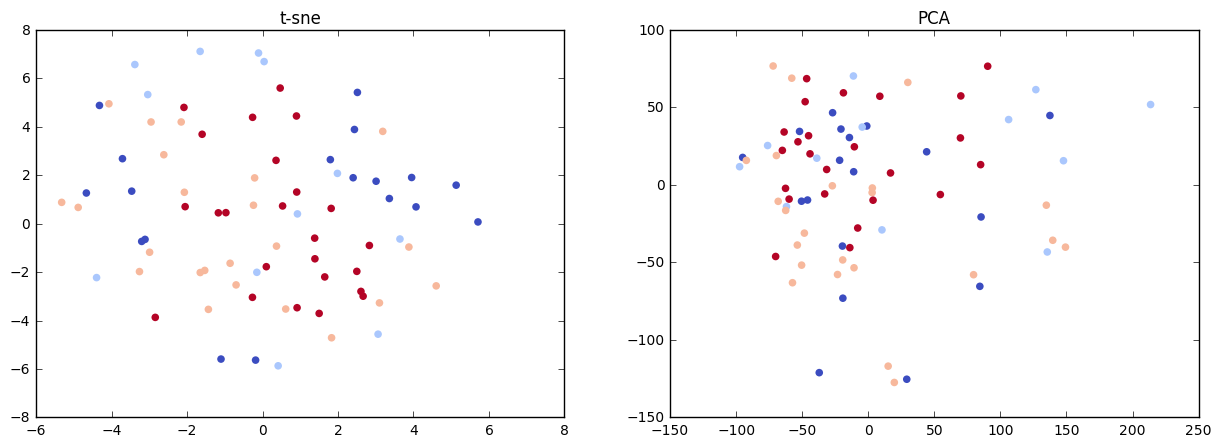

In [22]:
# plot out the result
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=1, s=30, lw=0, c=y, cmap = 'coolwarm')
ax1.set_title('t-sne')
ax2 = plt.subplot(122)
ax2.scatter(X_pca[:, 0], X_pca[:, 1], alpha = 1, s=30, lw=0, c=y, cmap = 'coolwarm')
ax2.set_title('PCA')
plt.show()
# check out hte terrible result.

### Explore visualization using t-sne
I read an interesting paper about Drop-Seq data analysis using t-sne to identify different types of cells according to transcriptome.   
**The key for this analysis is to visualize the intermediate steps of t-sne transformation.**    
This represent a potential approach that I could use for my project later on.  
**Here, I will test this approach and write it up from 'bottom up'.**

In [23]:
# write a temp_scatter for this particular visualization
# plotting out the t-sne with labels at the geometric center of different group of patients
def temp_scatter(x, colors):
    
    import seaborn as sns
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(6, 6))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    labels = ['Basal-like', 'HER2', 'LumA', 'LumB']
    txts = []
    for i in range(4):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, labels[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [24]:
X_proj = TSNE(random_state=42,learning_rate=100, perplexity=50).fit_transform(X)

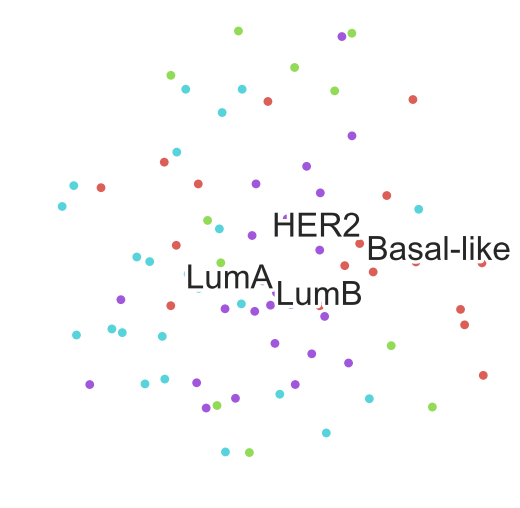

In [25]:
# here is one example of this temp_scatter, looks pretty good here.
temp_scatter(X_proj, y)
plt.show()

In [26]:
# monkey patch the _gradient_descent() and save the intermediate steps into a list called positions
positions = []
# the original code for _gradient_descent is 
# from https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/manifold/t_sne.py#L497
# version on Dec 25 2017 
def _gradient_descent(objective, p0, it, n_iter, objective_error=None,
                      n_iter_check=1, n_iter_without_progress=50,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # save the current position
        positions.append(p.copy())
        # after working on backprop in CNN, this is pretty easy
        new_error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)
        
        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if (i + 1) % n_iter_check == 0:
            if new_error is None:
                new_error = objective_error(p, *args)
            error_diff = np.abs(new_error - error)
            error = new_error

            if verbose >= 2:
                m = "[t-SNE] Iteration %d: error = %.7f, gradient norm = %.7f"
                print(m % (i + 1, error, grad_norm))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break
            if error_diff <= min_error_diff:
                if verbose >= 2:
                    m = "[t-SNE] Iteration %d: error difference %f. Finished."
                    print(m % (i + 1, error_diff))
                break

        if new_error is not None:
            error = new_error

    return p, error, i
# replace the original _gradient_descent with this
# this is little hacky, as soon as this function got updated, this will be broken
# currently, I cannot find a module to do it
# add a suggestion to the sckit learn 
sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [27]:
# here is one example of this visualization
X_proj = TSNE(random_state=42,learning_rate=10, perplexity=50).fit_transform(X)

In [28]:
X_iter = np.dstack(position.reshape(-1, 2) for position in positions)

In [29]:
X_iter.shape

(77, 2, 125)

**Quick notes:**
something wrong with moviepy at Dec 2017, thus, I used a hacky way here to save the t-sne intermediate steps as gif.
~~~~
for i in range(125):
    f, ax, sc, txts = scatter(X_iter[..., i], y)
    f.savefig(str(i))
    
import os
png_list = [_ for _ in os.listdir() if _[-3:] == 'png']

def getint(name):
    basename = name.split('.')[0]
    num = basename
    return int(num)
png_list.sort(key=getint)

import imageio
images = []
for filename in png_list:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)
~~~~
**Here is one example of visualization of intermediate steps in t-sne transformation**   
Notice how t-sne works on 1st axis first and then works on 2nd axis.    
And notice how terribly different patient groups are seperated.
<img src="movie.gif">

### Extract the correct feature sets
The goal of this section is extract the correct feature sets so that it is easier to find clusters and seperate them.   
**I am not using the statistical method here, since I found that the PAM50 RNA category is based on RNA-Seq data.**   
Thus, using the proteins that were translated from these RNAs should be the 'perfect' feature sets here.
**Here, I am just using the 'domain knowledge' to extract the feature sets'**

In [30]:
pam_file = 'breastcancerproteomes/PAM50_proteins.csv'

In [31]:
pam = pd.read_csv(pam_file)
pam.head()

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


### This section is just cleaning-up the dataset and extract the features and targets

In [32]:
prot_file = '77_cancer_proteomes_CPTAC_itraq_transposed.csv'
proteome_pam = pd.read_csv(prot_file, index_col=0)
proteome_pam.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [33]:
# proteome_pam.columns = proteome_pam.ix[0, :]
# proteome_pam = proteome_pam.ix[:, 1:]
# proteome_pam.head()

In [34]:
proteome_p50 = proteome_pam.ix[:,proteome_pam.columns.isin(pam['RefSeqProteinID'])]
proteome_p50.shape

(83, 43)

In [35]:
merge_p50 = proteome_p50.merge(clinic,left_index=True,right_index=True)
merge_p50.head()
merge_p50.to_csv('merge_p50.csv')

In [36]:
proteome_p50 = merge_p50.ix[:, :43]
imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(proteome_p50)
X_p50 = imputer.transform(proteome_p50)

In [37]:
merge_p50['PAM50 mRNA'] = merge_p50['PAM50 mRNA'].astype('category')
merge_p50['PAM50_mRNA_label'] = merge_p50['PAM50 mRNA'].cat.codes

In [38]:
y_p50 = merge_p50['PAM50_mRNA_label'].values

### Visualization via t-sne or PCA

In [39]:
X_p50_tsne = TSNE(random_state = 42, perplexity=30, learning_rate=30).fit_transform(X_p50)
X_p50_pca = PCA().fit_transform(X_p50)

In [40]:
len(X_p50_tsne)

77

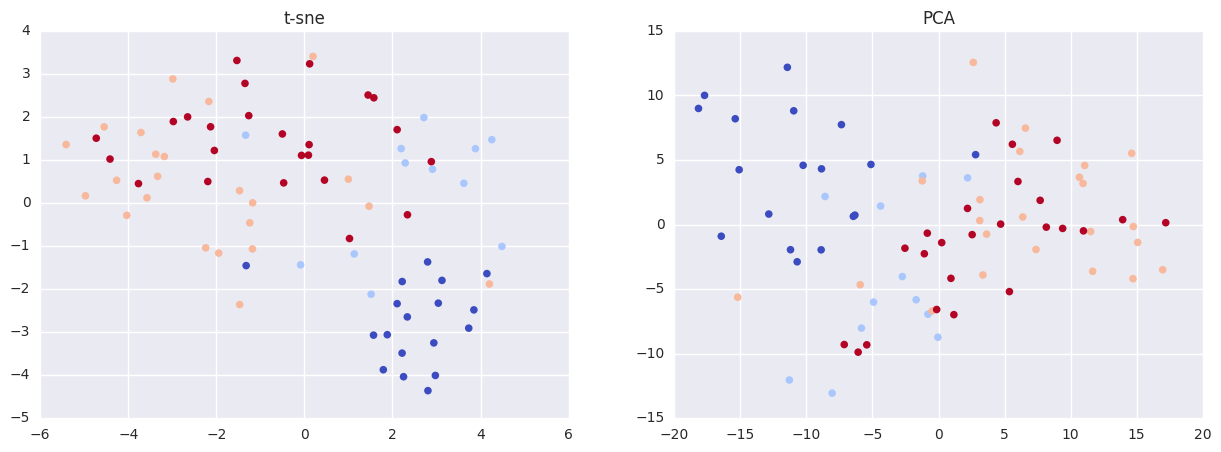

In [41]:
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.scatter(X_p50_tsne[:, 0], X_p50_tsne[:, 1], alpha=1, s=30, lw=0, c=y_p50, cmap = 'coolwarm')
ax1.set_title('t-sne')
ax2 = plt.subplot(122)
ax2.scatter(X_p50_pca[:, 0], X_p50_pca[:, 1], alpha = 1, s=30, lw=0, c=y_p50, cmap = 'coolwarm')
ax2.set_title('PCA')
plt.show()

#### Visualization of intermediate steps of t-sne transformation
Notice that we can **visualize different clusters now!**  
More importantly, through the data structure, I conclude that it will be easy to tell the 'basal-like' and 'HER2' and 'LUMA&B' from each other.    
However, it is hard to tell 'LumA' and 'LumB' from each other.  
Let's check if this observation is true using K-N or SVM models.
 <img src="movie2.gif">

### Machine Learning
To test my hypothesis previously and test if ML models could tell the patients apart from proteome data.   
I used 2 models here: K-neighbor and SVM.   
Clearly, these are not the most advanced algorithm any longer.   
I will explore the neural network in other scripts.

In [53]:
# KN
# Use K-neighbor to get a general idea of how accurate the prediction could be.
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
from sklearn import svm

cv = KFold(n=len(X_p50), shuffle=True)

for n_neighbors in [1, 3, 5, 7, 10, 20]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X_p50, y_p50, cv=cv)
    print("n_neighbors: %d, average score: %f" % (n_neighbors, np.mean(scores)))

n_neighbors: 1, average score: 0.290193
n_neighbors: 3, average score: 0.660622
n_neighbors: 5, average score: 0.681559
n_neighbors: 7, average score: 0.669095
n_neighbors: 10, average score: 0.683680
n_neighbors: 20, average score: 0.523664


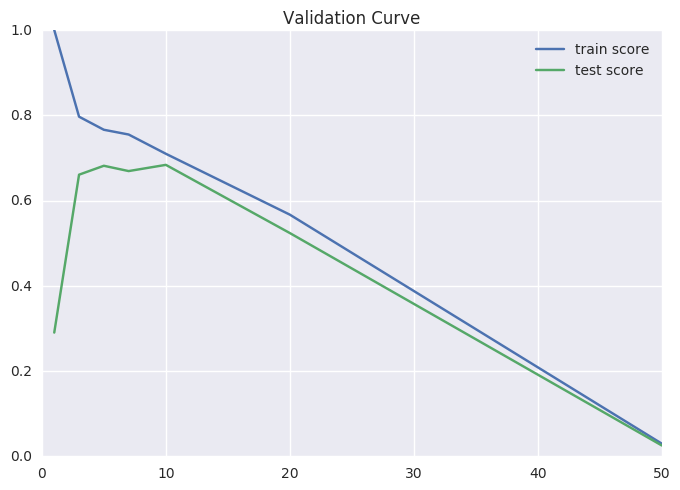

In [54]:
# the difference between train score and test score is low, indicating low bias in the model
# However, the highest score is only around 70%, not high at all.
# I will talk about the reason at the end of this notebook.
from sklearn.learning_curve import validation_curve
n_neighbors = [1, 3, 5, 7, 10, 20, 50]
train_errors, test_errors = validation_curve(KNeighborsRegressor(), X_p50, y_p50, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)
plt.plot(n_neighbors, train_errors.mean(axis=1), label="train score")
plt.plot(n_neighbors, test_errors.mean(axis=1), label="test score")
plt.legend(loc="best")
plt.title('Validation Curve')
plt.show()

In [60]:
# Try SVM to see the best prediction score that we can get.

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_p50, y_p50, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [61]:
# The best score we get is 0.75, not so good, the important question then become:
# What part does the algorithm mess up?
# To answer this question, we should go with the detailed prediction result
clf = GridSearchCV(svm.SVC(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.75

Confusion matrix, without normalization
[[5 0 1 0]
 [0 2 0 1]
 [0 0 5 1]
 [0 0 2 3]]


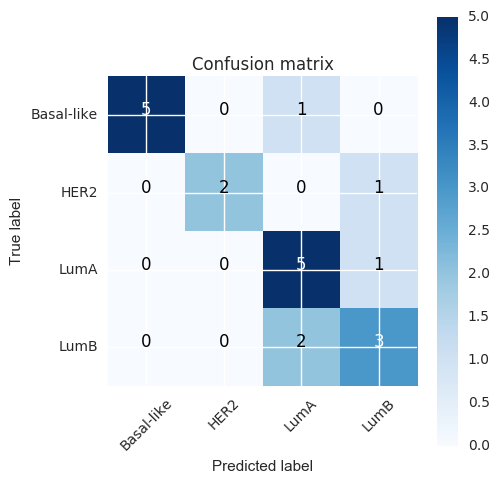

In [59]:
# To test the prediction result, here I implement to plot out the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(5,5))   
plot_confusion_matrix(cnf_matrix, classes=['Basal-like', 'HER2', 'LumA', 'LumB'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

#### My prediction holds true that it is hard for the algorithm to tell LumA and LumB apart.     
This conclusion is consistent with previous research. In the previous reseach, they concluded using PAM50 proteome, it is better to seperate patients into 3 categories: Basal-like, HER2 and LumA/B since there is not enough information to tell LumA and LumB patients apart.

So, why don't I try that and see how the SVM model perform?

In [64]:
y_p50_3_cat = []
for _ in y_p50:
    if _ == 3:
        y_p50_3_cat.append(2)
    else:
        y_p50_3_cat.append(_)
y_p50_3_cat = np.array(y_p50_3_cat)

In [73]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_p50, y_p50_3_cat, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(svm.SVC(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
# around 85% of predictions are right. Not bad, not bad

0.84999999999999998

Confusion matrix, without normalization
[[ 3  0  0]
 [ 0  1  2]
 [ 1  0 13]]


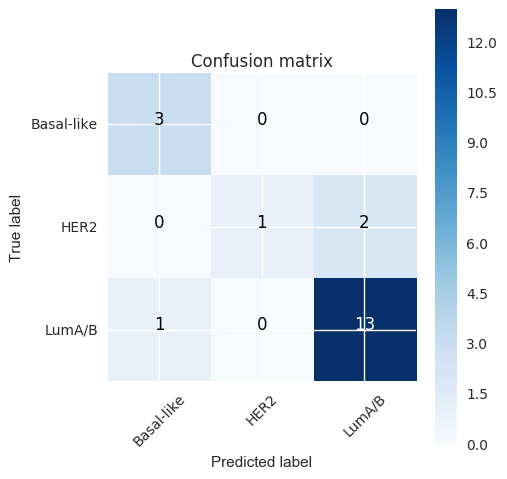

In [75]:
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(5,5))   
plot_confusion_matrix(cnf_matrix, classes=['Basal-like', 'HER2', 'LumA/B'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
# consistent with previous study, much higher precision

### Future Plan
Clearly, choosing PAM50 genes means that we neglect a lot of information. The correct way to to utilize all the proteome data. However, the t-sne clearly showed no clusters regarding all proteome information. One choice is to get more/ much more patient samples. However, it is always hard/ expensive to get more samples. Another choice is to use more advanced algorithm (NN).    
Since I only have a laptop with integrated video card. I will not explore the Neural Network (deep learning) part in detail. I am planning to use Keras module to construct a simple neural network to see how NN performs.